<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-David-Nicolas364/blob/main/Proyecto%3Afinal/Proyecto_final_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Proyecto capaz de detectar fake news
David Nicolás Cruz Benítez

El objetivo de este código es que por medio del uso de redes neuronales sea capaz de aprender de nuetro conjunto de datos y por medio de una red neuronal se pueda detectar entre noticias verdaderas y noticias falsas. Este tipo de aprendizaje es supervisado ya que al programa se le dan noticias que ya se conocen como verdaderas o falsas y pasan por una red neuronal.

Table of contents:
*   Introducción
*   Imports e installs
*   Procesamiento de datos
*   Modelo de Machine Learning




##Imports e installs

Se usará la librería stop_words ya que está nos ayudará en el procesamiento de palabras a disminuir la cantidad de palabras en nuestros textos

In [1]:
!pip install stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=ec92550ccd0d872c50d80af0e2d4155f712928d0694c0d57aa75aae953ef738c
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Procesado de datos

Dedibo a que los datos son texto lo primero que tenemos que hacer es cambiar los datos a número para que así se pueda entender en el programa y puedan ser usados en la red neuronal.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Cosas ML/train_set.csv/train.csv")

In [4]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


Datos obtenidos de: https://kaggle.com/competitions/fake-news.

En este dataframe se presenta una identificación para cada noticia, así como: el título del artículo, el autor y el texto, además para este dataset se nos presenta si las noticias son verdaderas si en label contienen un 0 y es falsa si contiene un 1

In [5]:
df.shape

(20800, 5)

Verificamos que en nuestros datos no hayan datos vacios

In [6]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

Eliminamos estos renglones con datos faltantes

In [7]:
dat = df.dropna()

In [8]:
dat.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [9]:
dat.shape

(18285, 5)

El siguiente paso es la eliminación de palabras que no nos aporten nada en el análisis del texto usando la librería stop_word, además de otros caracteres que no sean alfanuméricos fuera de las palabras

Las stopwords en inglés son:

In [10]:
print(get_stop_words("en"))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

In [11]:
#se usan las stop words en inglés
#En este paso quitamos las stopwords y simbolos no alfanuméricos que no esten acompañados por carácters alfanuméricos
stop_words = get_stop_words("en")
punctuations = "'!()-[]{};:',#$%&/=?´+@^`~\*.-"
def quitar_palabras(texto):
  palabras = texto.split()
  palabras_buenas =[]
  for i in range(len(palabras)):
    if palabras[i] not in stop_words and palabras[i] not in punctuations:
      palabras_buenas.append(palabras[i])
  good_words = ' '.join(palabras_buenas)
  return good_words

Se usa la librería re, que su uso principal es para la identificación de tipos de caracterés, en este caso uso \d para números \W para caracterés no alfanúmericos que se encuentren acompañadas por carácteres alfanuméricos

In [12]:
def limpiar(cuerpo):
  #se usa re.compile para tener un tipo de patrón
  #en este se encuentran números
  patron = re.compile('\d' )
  #aquí se encuentra carácteres no alfanúmericos
  patron2 = re.compile('\W' )
  #se cambian a minúsculas
  cuerpo = cuerpo.lower()
  #Se sustituyen los carácteres del patrón1
  cuerpo = patron.sub('', cuerpo)
  #Se sustituyen los carácteres del patrón2
  cuerpo = patron2.sub(' ', cuerpo)
  #Se utilliza la función anterior para quitar stop-words y carácteres no alfanuméricos
  cuerpo = quitar_palabras(cuerpo)
  return cuerpo

Se crea otra columna que contenga el texto ya limpio de los artículos

In [13]:
dat['limpio'] = dat.text.map(lambda x: limpiar(x))

<ipython-input-13-2708f10d460e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['limpio'] = dat.text.map(lambda x: limpiar(x))


In [14]:
dat

,id,title,author,text,label,limpio
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didn t even see comey s letter ...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october tension intellig...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians killed single us airstrike id...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,rapper t unloaded black celebrities met donald...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,green bay packers lost washington redskins wee...
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,macy s today grew union several great names am...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,nato russia hold parallel exercises balkans pr...


Para reducir aún más el número de palabras usaremos el proceso stemming que lo que realizará es la reducción de palabras a su raíz, por ejemplo:
actor, actriz, actuar -> acto

In [15]:
#Función para stemming
port_stem = PorterStemmer()

In [16]:
#Aplicando la función de stemming en cada palabra
def stemming(contenido):
  stemmed_contenido = contenido.split()
  stemmed_contenido = [port_stem.stem(word) for word in stemmed_contenido]
  stemmed_contenido = ' '.join(stemmed_contenido)
  return stemmed_contenido

In [17]:
#Aplicando en la columna anteriormente limpiada
dat['limpio'] = dat['limpio'].apply(stemming)

<ipython-input-17-158a8a8d9a92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['limpio'] = dat['limpio'].apply(stemming)


In [18]:
corpus = dat.limpio.values

El siguiente paso es convertir cada texto en una lista, se usará la paquetería nltk y la función TweetTokenizer

In [19]:
tknzr=TweetTokenizer()
#impresión del primer texto como ejemplo
tknzr.tokenize(corpus[0])

['hous',
 'dem',
 'aid',
 'didn',
 't',
 'even',
 'see',
 'comey',
 's',
 'letter',
 'jason',
 'chaffetz',
 'tweet',
 'darrel',
 'lucu',
 'octob',
 'subscrib',
 'jason',
 'chaffetz',
 'stump',
 'american',
 'fork',
 'utah',
 'imag',
 'courtesi',
 'michael',
 'jolley',
 'avail',
 'creativ',
 'common',
 'licens',
 'apolog',
 'keith',
 'olbermann',
 'doubt',
 'worst',
 'person',
 'world',
 'week',
 'fbi',
 'director',
 'jame',
 'comey',
 'accord',
 'hous',
 'democrat',
 'aid',
 'look',
 'like',
 'also',
 'know',
 'second',
 'worst',
 'person',
 'well',
 'turn',
 'comey',
 'sent',
 'now',
 'infam',
 'letter',
 'announc',
 'fbi',
 'look',
 'email',
 'may',
 'relat',
 'hillari',
 'clinton',
 's',
 'email',
 'server',
 'rank',
 'democrat',
 'relev',
 'committe',
 'didn',
 't',
 'hear',
 'comey',
 'found',
 'via',
 'tweet',
 'one',
 'republican',
 'committe',
 'chairmen',
 'now',
 'know',
 'comey',
 'notifi',
 'republican',
 'chairmen',
 'democrat',
 'rank',
 'member',
 'hous',
 'intellig',
 '

Se usa un ciclo for para realizarlo en cada texto

In [20]:
corpus_tk=[]
for i in corpus:
  corpus_tk.append(tknzr.tokenize(i))

El siguiente paso es convertir cada palabra a una representación vectorial esto se hace por un método llamado Word2Vec en la cual a una palabra se le da un vector y cada palabra se puede relacionar a otra similar por medio de suma o resta vectorial.

In [21]:
#Se da la entrada de los textos a representar, en min_count es la cantidad necesaria a repetirse una palabra para tomarse en cuenta
#En window es una ventana de contexto
#size representa el tamaño del vector de cada palabra
model = Word2Vec(corpus_tk, min_count=50, window = 5, vector_size=100)

In [22]:
X = model.wv.vectors

In [23]:
X.shape

(10246, 100)

Vamos a reducir la dimensionalidad del modelo de Word2Vec ya que al tener más componentes va a ser más complejo al aplicarlo en la red neuronal

Usaremos PCA para reducir los componentes de los vectores, en el gráfico se presenta el porcentaje de varianza que se perderá en función al número de componentes principales

Text(0.5, 0, 'Componentes PCA')

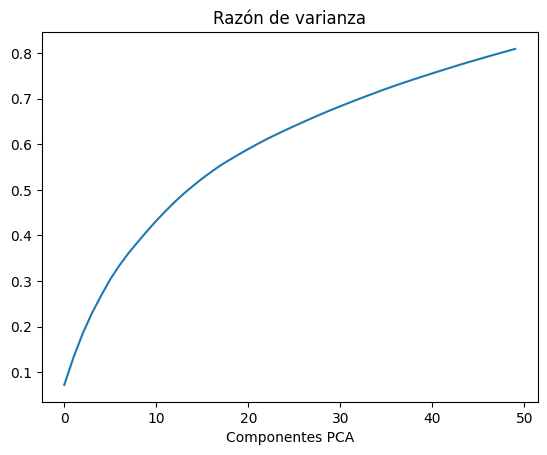

In [24]:
pca = PCA(n_components=50, svd_solver='full')
pca.fit(X)
plt.plot((pca.explained_variance_ratio_).cumsum())
plt.title('Razón de varianza')
plt.xlabel('Componentes PCA')

Se puede observar que con 30 componentes se queda con el 70% de la varianza que parece ser un buen punto para no tener mucha complejidad

In [25]:
pca = PCA(n_components=30, svd_solver='full')
pca.fit(X)

PCA(n_components=30, svd_solver='full')

Con lo que obtenemos una representación vectorial de cada palabra de 30 componentes

In [26]:
#En este proseso se le asignan valores a las palabras en función de las veces que se repite una palabra y se le da un mínimo de repeticiones
vectorizer = TfidfVectorizer(min_df=30)
TF_IDF=vectorizer.fit_transform(corpus)

In [27]:
#Aquí se muestra el número de noticias y el número de palabras que encontró
TF_IDF.toarray().shape

(18285, 10927)

Se guardará la posición de cada palabra

In [28]:
#En este se guarda la posición de cada palabra de los textos
tf_idf=vectorizer.vocabulary_

In [29]:
#La posición en el array TF_IDF
tf_idf['usa']

10325

In [30]:
#El valor del tfidf de la palabra
TF_IDF[0, tf_idf['usa']]

0.0

Para convertir un texto en su representación numérica lo que haremos será calcular la media entre la representación numérica de cada palabra y lo que nos salga es la representación vectorial del texto

Se creará un array de la representación numérica de cada noticia

In [31]:
#Aquí se van a guardar los valores
x=np.zeros((dat.shape[0],30))
for i,corp in enumerate(corpus):
  vect = np.zeros(100)
  for num,word in enumerate(corp.split(' ')):
    try:
      #Se multiplica el vector que representa la paabra según el modelo de Word2Vec por el valor de TFIDF que depende de la frecuencia de una palabra en el texto
      vect+=model.wv[word]*TF_IDF[i,tf_idf[word]]
    except:
        pass
  if num!=0:
    #Se divide por el número de palabras del texto
     vect=vect/num
  else:
      vect=vect*0
  #Aquí se consigue el vector que representa al texto i
  vect=vect.reshape(1,100)
  #Con el PCA se cambia la cantdad de componentes de 100 a 30
  vect_pca=pca.transform(vect)
  x[i,:] = vect_pca

In [32]:
x

array([[ 0.40908001,  0.40298326, -0.19336278, ..., -0.04001937,
        -0.01682588,  0.0711067 ],
       [ 0.41466994,  0.24435803, -0.20420928, ..., -0.01457204,
        -0.05831451,  0.05100412],
       [ 0.49192543,  0.24703129, -0.10241533, ..., -0.03138581,
        -0.05064679,  0.04355098],
       ...,
       [ 0.29344628,  0.16769672,  0.00838723, ..., -0.01446012,
        -0.02664842,  0.08684712],
       [ 0.65591005,  0.30526241,  0.09404599, ...,  0.09071853,
        -0.02083242,  0.09837418],
       [ 0.37656863,  0.23329792, -0.08560109, ..., -0.02823616,
        -0.05892664,  0.06692057]])

In [33]:
#El label del dataframe nos muestra si la noticia es verdadera o falsa
Y = dat['label'].values

In [34]:
Y.shape

(18285,)

In [35]:
#Se divide en los datos de pruebas y entrenamiento
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.2, stratify=Y, random_state=2)

In [36]:
x_train

array([[ 0.39618277,  0.12250518, -0.08405729, ..., -0.02225385,
        -0.0622157 ,  0.05181256],
       [ 0.35738724,  0.20687739, -0.05125685, ..., -0.03585227,
        -0.03911528,  0.06830773],
       [ 0.30294219,  0.38814441, -0.18186907, ..., -0.06094072,
        -0.0161082 ,  0.07809866],
       ...,
       [ 0.27126479,  0.18355002, -0.09045611, ...,  0.10467181,
        -0.10344885,  0.08868631],
       [ 0.37785366,  0.18194171, -0.0654031 , ..., -0.01559329,
        -0.04691482,  0.06159927],
       [ 0.27274733,  0.1605651 , -0.10829258, ..., -0.00374646,
        -0.04762884,  0.06708807]])

In [37]:
x_test

array([[ 7.23716238e-01,  2.18564771e-01, -1.52911231e-01, ...,
        -6.12796096e-02,  1.99051995e-02,  1.39232039e-02],
       [ 7.44780823e-01,  4.57547569e-01, -4.24764848e-02, ...,
         6.44750968e-03,  9.91140680e-03,  1.56194632e-02],
       [ 3.02836265e-01,  4.04077712e-01, -2.26474967e-02, ...,
         1.09828648e-02, -2.95530242e-02,  2.16402246e-02],
       ...,
       [ 5.65929278e-01,  5.11730122e-01, -1.05642086e-01, ...,
         4.88678370e-03, -4.38397153e-02,  3.86089016e-02],
       [ 3.78439904e-01,  5.14255609e-01, -1.44848082e-01, ...,
        -6.94714454e-05, -5.55235145e-02,  6.15409289e-02],
       [ 6.37542577e-01,  3.90768665e-01, -1.13785687e-01, ...,
         4.71981062e-02, -5.96540800e-02,  3.72209957e-02]])

Normalización

In [38]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [39]:
x_test

array([[ 1.61837212, -0.37878332, -0.29951234, ..., -0.715864  ,
         1.60147151, -0.77048782],
       [ 1.73019611,  1.24334988,  0.55327305, ...,  0.28544359,
         1.33554279, -0.73657033],
       [-0.61592194,  0.88041484,  0.70639398, ...,  0.35249628,
         0.28541838, -0.61618243],
       ...,
       [ 0.78074028,  1.61112245,  0.06550354, ...,  0.26236913,
        -0.09474174, -0.27688589],
       [-0.21457055,  1.62826459, -0.2372481 , ...,  0.18909367,
        -0.40564051,  0.1816506 ],
       [ 1.16090845,  0.7900776 ,  0.00261804, ...,  0.88791838,
        -0.51555233, -0.30463771]])

In [40]:
print(Y)

[1 0 1 ... 0 1 1]


# Modelo de Machine learning

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

Modelo 1 (3 capas ocultas

In [42]:
tf.random.set_seed(1234)
model1 = Sequential([
  tf.keras.Input(shape=(x_train.shape[1])),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(1,activation='sigmoid')
])

In [43]:
model1.compile(optimizer='sgd', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [44]:
historial = model1.fit(x_train, y_train, epochs = 60)

Epoch 1/60
458/458 [==============================] - 2s 3ms/step - loss: 0.6184 - accuracy: 0.6923
Epoch 2/60
458/458 [==============================] - 1s 3ms/step - loss: 0.4635 - accuracy: 0.8005
Epoch 3/60
458/458 [==============================] - 2s 4ms/step - loss: 0.4070 - accuracy: 0.8191
Epoch 4/60
458/458 [==============================] - 2s 4ms/step - loss: 0.3842 - accuracy: 0.8307
Epoch 5/60
458/458 [==============================] - 2s 4ms/step - loss: 0.3686 - accuracy: 0.8421
Epoch 6/60
458/458 [==============================] - 1s 3ms/step - loss: 0.3560 - accuracy: 0.8494
Epoch 7/60
458/458 [==============================] - 1s 3ms/step - loss: 0.3462 - accuracy: 0.8549
Epoch 8/60
458/458 [==============================] - 1s 3ms/step - loss: 0.3374 - accuracy: 0.8573
Epoch 9/60
458/458 [==============================] - 1s 3ms/step - loss: 0.3292 - accuracy: 0.8610
Epoch 10/60
458/458 [==============================] - 1s 3ms/step - loss: 0.3221 - accuracy: 0.8656

In [45]:
cost, ac = model1.evaluate(x_test, y_test)

print('Cost: {}, Accuracy: {}'.format(cost, ac))

115/115 [==============================] - 0s 2ms/step - loss: 0.3905 - accuracy: 0.8608
Cost: 0.3904837667942047, Accuracy: 0.8608148694038391


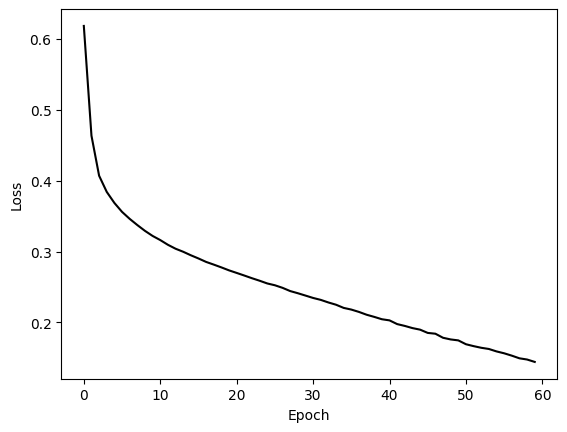

In [46]:
plt.plot(historial.history['loss'], color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

En este primer modelo use 3 capas ocultas con una función de activación de tipo Relu para que tenga una buena taza de aprendizaje y en la capa de salida usé una de tipo sigmoide debido a que como mi resultado será un 1 o un 0 que nos representará si la noticia es verdadera o falsa yu como la función sigmoide beneficia ya que mayormente nos puede dar valores entre 0 y 1. Empiezo con 60 epocas para mi primer modelo y aunque la perdida sigue disminuyendo y la presición aumenta en la prueba con los datos de prueba  el costo es significativo por lo que puede ser que se haya sobre ajustado ya que la presición es muy alta en el modelo de entrenamiento.

Modelo 2( 2 capas ocultas de 500 neuronas)

In [47]:
tf.random.set_seed(1234)
model2 = Sequential([
  tf.keras.Input(shape=(x_train.shape[1])),
  Dense(500, activation='relu'),
  Dense(500, activation='relu'),
  Dense(1,activation='sigmoid')
])

In [48]:
model2.compile(optimizer='sgd', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [49]:
historial2 = model2.fit(x_train, y_train, epochs = 60)

Epoch 1/60
458/458 [==============================] - 3s 5ms/step - loss: 0.5776 - accuracy: 0.7448
Epoch 2/60
458/458 [==============================] - 2s 5ms/step - loss: 0.4596 - accuracy: 0.8069
Epoch 3/60
458/458 [==============================] - 3s 6ms/step - loss: 0.4157 - accuracy: 0.8200
Epoch 4/60
458/458 [==============================] - 4s 8ms/step - loss: 0.3948 - accuracy: 0.8281
Epoch 5/60
458/458 [==============================] - 3s 6ms/step - loss: 0.3803 - accuracy: 0.8341
Epoch 6/60
458/458 [==============================] - 2s 5ms/step - loss: 0.3692 - accuracy: 0.8389
Epoch 7/60
458/458 [==============================] - 2s 5ms/step - loss: 0.3606 - accuracy: 0.8440
Epoch 8/60
458/458 [==============================] - 2s 5ms/step - loss: 0.3528 - accuracy: 0.8497
Epoch 9/60
458/458 [==============================] - 2s 5ms/step - loss: 0.3461 - accuracy: 0.8544
Epoch 10/60
458/458 [==============================] - 4s 8ms/step - loss: 0.3401 - accuracy: 0.8570

In [50]:
cost, ac = model2.evaluate(x_test, y_test)

print('Cost: {}, Accuracy: {}'.format(cost, ac))

115/115 [==============================] - 1s 3ms/step - loss: 0.3301 - accuracy: 0.8616
Cost: 0.3301331698894501, Accuracy: 0.8616352081298828


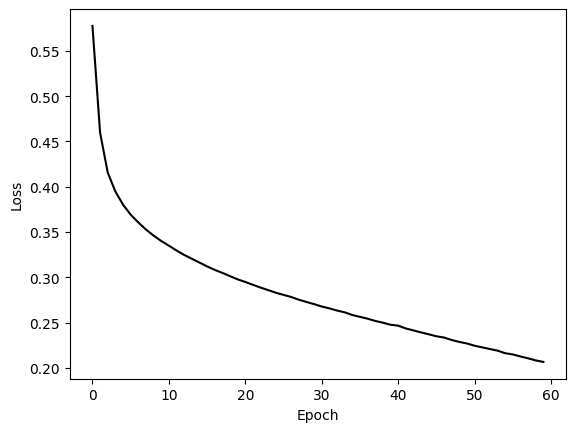

In [51]:
plt.plot(historial2.history['loss'], color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

En mi segundo modelo se disminiyó la cantidad de capas y se aumento el número de neuronas en cada una de 200 a 500, considero que que la presición es demasiada alta por que pueda a llevar a un sobreajuste, por lo que para los siguientes modelos cambiaré el número de epocas también. En este modelo mejoró  el costo en los datos de prueba, aunque fueran menos capas ocultas.

Modelo 3 (5 capas ocultas de 200 neuronas)

In [52]:
tf.random.set_seed(1234)
model3 = Sequential([
  tf.keras.Input(shape=(x_train.shape[1])),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(1,activation='sigmoid')
])

In [53]:
model3.compile(optimizer='sgd', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [54]:
historial3 = model3.fit(x_train, y_train, epochs = 50)

Epoch 1/50
458/458 [==============================] - 2s 3ms/step - loss: 0.6175 - accuracy: 0.6923
Epoch 2/50
458/458 [==============================] - 2s 4ms/step - loss: 0.4522 - accuracy: 0.8000
Epoch 3/50
458/458 [==============================] - 2s 4ms/step - loss: 0.3935 - accuracy: 0.8274
Epoch 4/50
458/458 [==============================] - 2s 3ms/step - loss: 0.3660 - accuracy: 0.8426
Epoch 5/50
458/458 [==============================] - 2s 5ms/step - loss: 0.3448 - accuracy: 0.8547
Epoch 6/50
458/458 [==============================] - 2s 5ms/step - loss: 0.3292 - accuracy: 0.8640
Epoch 7/50
458/458 [==============================] - 2s 5ms/step - loss: 0.3160 - accuracy: 0.8690
Epoch 8/50
458/458 [==============================] - 2s 3ms/step - loss: 0.3055 - accuracy: 0.8717
Epoch 9/50
458/458 [==============================] - 2s 3ms/step - loss: 0.2955 - accuracy: 0.8752
Epoch 10/50
458/458 [==============================] - 2s 4ms/step - loss: 0.2862 - accuracy: 0.8799

In [55]:
cost, ac = model3.evaluate(x_test, y_test)

print('Cost: {}, Accuracy: {}'.format(cost, ac))

115/115 [==============================] - 0s 2ms/step - loss: 0.5202 - accuracy: 0.8622
Cost: 0.5202323794364929, Accuracy: 0.8621821403503418


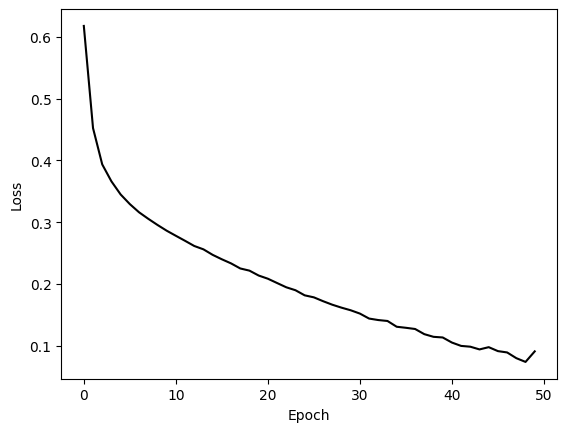

In [56]:
plt.plot(historial3.history['loss'], color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Este modelo salió bastante malo al usarse 5 capas con 200 neuronas, la pérdida es bastante alta en comparación de los modelos anteriores por lo que concluyo que no es necesario tener una alta cantidad de capas para mejorar la perdida al aplicar el modelo, en el siguiente modelo aumentare la cantidad de neuronas y evitaré tener una alta cantidad de capas

Modelo 4 (3 capas ocultas de 1000 neuronas)

In [63]:
tf.random.set_seed(1234)
model4 = Sequential([
  tf.keras.Input(shape=(x_train.shape[1])),
  Dense(1000, activation='relu'),
  Dense(1000, activation='relu'),
  Dense(1,activation='sigmoid')
])

In [64]:
model4.compile(optimizer='sgd', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [65]:
historial4 = model4.fit(x_train, y_train, epochs = 50)

Epoch 1/50
458/458 [==============================] - 8s 16ms/step - loss: 0.5719 - accuracy: 0.7514
Epoch 2/50
458/458 [==============================] - 6s 12ms/step - loss: 0.4542 - accuracy: 0.8068
Epoch 3/50
458/458 [==============================] - 6s 12ms/step - loss: 0.4130 - accuracy: 0.8219
Epoch 4/50
458/458 [==============================] - 7s 16ms/step - loss: 0.3925 - accuracy: 0.8298
Epoch 5/50
458/458 [==============================] - 5s 12ms/step - loss: 0.3782 - accuracy: 0.8362
Epoch 6/50
458/458 [==============================] - 7s 14ms/step - loss: 0.3671 - accuracy: 0.8404
Epoch 7/50
458/458 [==============================] - 6s 14ms/step - loss: 0.3585 - accuracy: 0.8456
Epoch 8/50
458/458 [==============================] - 5s 12ms/step - loss: 0.3505 - accuracy: 0.8507
Epoch 9/50
458/458 [==============================] - 8s 16ms/step - loss: 0.3436 - accuracy: 0.8554
Epoch 10/50
458/458 [==============================] - 5s 12ms/step - loss: 0.3375 - accura

In [66]:
cost, ac = model4.evaluate(x_test, y_test)

print('Cost: {}, Accuracy: {}'.format(cost, ac))

115/115 [==============================] - 1s 8ms/step - loss: 0.3268 - accuracy: 0.8666
Cost: 0.32677769660949707, Accuracy: 0.8665573000907898


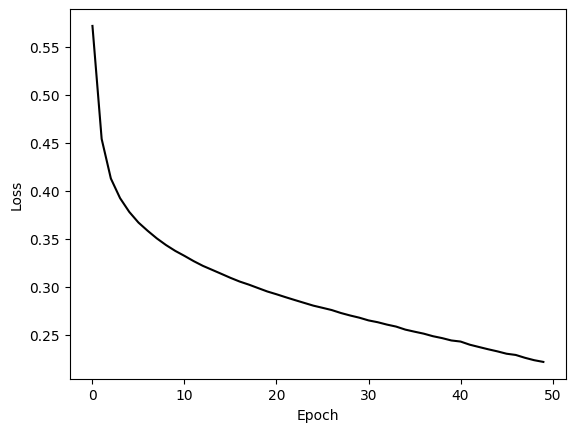

In [67]:
plt.plot(historial4.history['loss'], color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#Conclusión